# **Transfert learning**

In [1]:
#import tensorflow as tf
from tensorflow import device
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.applications.vgg16 import VGG16

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

#from glob import glob  # Récupération des emplacements de fichiers
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
import random  # Utilisé lors de la séparation train/test
from math import ceil  # Utilisé lors de la séparation train/test


2023-11-30 15:26:45.606897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 15:26:45.606945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 15:26:45.606968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 15:26:45.612994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Séparation des images en train/test en créant un nouveau dossier.

In [2]:
split_ratio = 0.8

#input_folder = "dogs_small_proc"
#input_folder = "dogs_small_proc_white"
input_folder = "dogs_small"

output_folder = input_folder + "_splited"


# Si le dossier existe déjà (précédente sauvagarde)
# suppression du dossier et de son contenu avec shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Créer les dossiers train et test dans le dossier de sortie
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Parcourir les sous-dossiers du dossier d'origine
for label_folder in os.listdir(input_folder):
    label_path = os.path.join(input_folder, label_folder)
    if os.path.isdir(label_path):
        # Liste des fichiers dans le sous-dossier
        files = os.listdir(label_path)
        # Calculer le nombre de fichiers à utiliser pour l'entraînement
        train_count = ceil(len(files) * split_ratio)
        # Mélanger la liste des fichiers de manière aléatoire
        random.shuffle(files)
        
        # Diviser les fichiers entre train et test
        train_files = files[:train_count]
        test_files = files[train_count:]

        # Créer les sous-dossiers correspondants dans les dossiers train et test
        train_label_folder = os.path.join(train_folder, label_folder)
        test_label_folder = os.path.join(test_folder, label_folder)
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(test_label_folder, exist_ok=True)

        # Copier les fichiers dans les sous-dossiers correspondants
        for file in train_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(train_label_folder, file))
        
        for file in test_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(test_label_folder, file))

In [3]:
path = output_folder+"/train"
path_test = output_folder+"/test"


https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [4]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    #dataset = tf.keras.utils.image_dataset_from_directory(
    dataset = image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [5]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 472 files belonging to 3 classes.
Using 354 files for training.


2023-11-30 15:27:01.349994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:27:01.354256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:27:01.354289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:27:01.355704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 15:27:01.355740: I tensorflow/compile

Found 472 files belonging to 3 classes.
Using 118 files for validation.
Found 117 files belonging to 3 classes.


In [6]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(3, activation='softmax')  # 4 (nombre de classes)
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [7]:
# Création du modèle
#with tf.device('/gpu:0'):
with device('/gpu:0'):    
    model = create_model_fct2()

# Création du callback
model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [8]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
#with tf.device('/gpu:0'):
with device('/gpu:0'): 
    history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


2023-11-30 15:27:05.928324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 15:27:06.125581: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 15:27:07.296545: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f36b09c0d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 15:27:07.296583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-30 15:27:07.300263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 15:27:07.374540: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - ETA: 0s - loss: 1.2409 - accuracy: 0.4153
Epoch 1: val_loss improved from inf to 0.79877, saving model to ./model_best_weights.h5


/home/maxime/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 5s 147ms/step - loss: 1.2409 - accuracy: 0.4153 - val_loss: 0.7988 - val_accuracy: 0.7542
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.5650
Epoch 2: val_loss improved from 0.79877 to 0.66579, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 84ms/step - loss: 0.9178 - accuracy: 0.5650 - val_loss: 0.6658 - val_accuracy: 0.8305
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.6808
Epoch 3: val_loss improved from 0.66579 to 0.55131, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 85ms/step - loss: 0.7649 - accuracy: 0.6808 - val_loss: 0.5513 - val_accuracy: 0.8559
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 0.6758 - accuracy: 0.7699
Epoch 4: val_loss improved from 0.55131 to 0.48257, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 85ms/st

In [10]:
# Score du dernier epoch

loss, accuracy = model.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

12/12 [==============================] - 1s 38ms/step - loss: 0.0595 - accuracy: 0.9859
Training Accuracy   : 0.9859

4/4 [==============================] - 0s 42ms/step - loss: 0.1750 - accuracy: 0.9237
Validation Accuracy :  0.9237


In [11]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.9237
Test Accuracy       :  0.9658


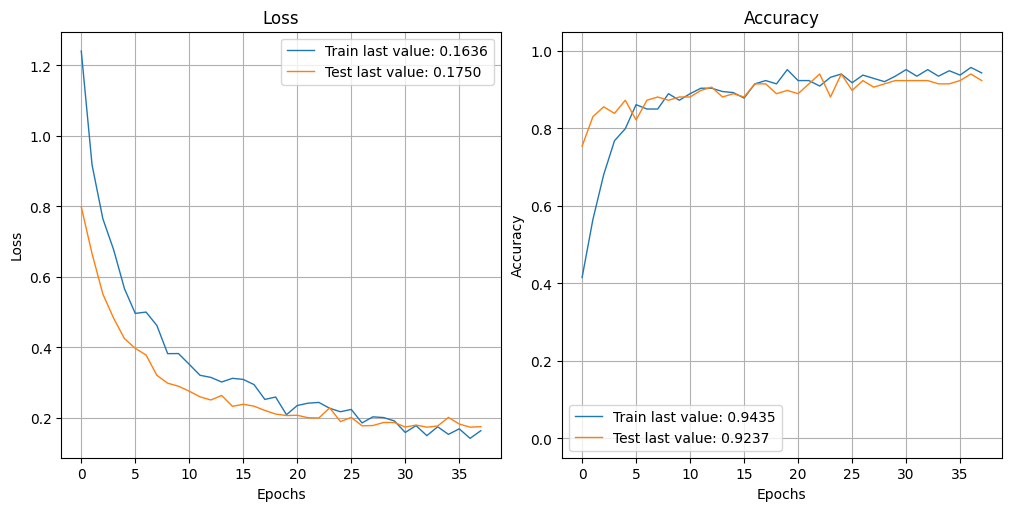

In [12]:


show_history(history)
plot_history(history, path="standard.png")
plt.close()